# Stable Diffusion Text-to-Image Demo

Stable Diffusion is an innovative generative AI technique that allows us to generate and manipulate images in interesting ways, including generating image from text and restoring missing parts of pictures (inpainting)!

Stable Diffusion <b>v2</b> provides great functionality over previous versions, including being able to use more data, employ more training, and has less restrictive filtering of the dataset. All of these features give us promising results for selecting a wide range of input text prompts!

**Note:** This is a shorter version of the [236-stable-diffusion-v2-text-to-image.ipynb](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/236-stable-diffusion-v2/236-stable-diffusion-v2-text-to-image.ipynb) notebook for demo purposes and to get started quickly. This version does not have the full implementation of the helper utilities needed to convert the models from PyTorch to ONNX to OpenVINO, and the OpenVINO OVStableDiffusion pipeline within the notebook directly. If you would like to see the full implementation of stable diffusion for text to image, please visit [236-stable-diffusion-v2-text-to-image.ipynb](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/236-stable-diffusion-v2/236-stable-diffusion-v2-text-to-image.ipynb).

## Step 0: Install and import prerequisites

In [1]:
from pathlib import Path

To work with Stable Diffusion v2, we will use Hugging Face's [Diffusers](https://github.com/huggingface/diffusers) library. 

To experiment with Stable Diffusion models, Diffusers exposes the [StableDiffusionPipeline](https://huggingface.co/docs/diffusers/using-diffusers/conditional_image_generation) and StableDiffusionInpaintPipeline, similar to the [other Diffusers pipelines](https://huggingface.co/docs/diffusers/api/pipelines/overview).  

In [2]:
!pip install -q "diffusers>=0.14.0" openvino-dev openvino "transformers >= 4.25.1" accelerate

## Step 1: Stable Diffusion v2 Fundamental components 

Stable Diffusion pipelines for both <i>Text to Image</i> and <i>Inpainting</i> consist of three important parts:

1. A Text Encoder to create conditions: for example, generating an image from a text prompt or performing inpainting to create an infinite zoom effect.
2. A U-Net for step-by-step denoising of latent image representation.
3. An Autoencoder (VAE) for decoding the latent space to an image.

Depending on the pipeline, the paramaters for these parts can differ, which we'll explore in this demo! 

### Step 1.1: Retrieve components from HuggingFace

Let's start by retrieving these components from HuggingFace!

The code below demonstrates how to create `StableDiffusionPipeline` using `stable-diffusion-2-1`.

In [3]:
# Retrieve the Text to Image Stable Diffusion pipeline components
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to("cpu")

# for reducing memory consumption get all components from pipeline independently
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

conf = pipe.scheduler.config

del pipe

text_encoder\model.safetensors not found


## Step 2: Convert the models to OpenVINO

Now that we've retrieved the three parts for both of these pipelines, we now need to:

1. Convert the original PyTorch models to ONNX format

```
with torch.no_grad():
    torch.onnx.export(model_part, image, onnx_path, input_names=[
                      '...'], output_names=['...'])
```

2. Convert these ONNX models to OpenVINO IR format, using Model Optimizer tool using:

```
!mo --input_model $onnx_file_path --output_dir $model_dir
```

We can then run our Stable Diffusion v2 text to image and inpainting pipelines in OpenVINO on our own data!

In [4]:
# Define a dir to save text-to-image models
txt2img_model_dir = Path("sd2.1")
txt2img_model_dir.mkdir(exist_ok=True)

In [5]:
from implementation.conversion_helper_utils import convert_txt_encoder_onnx_OV, convert_unet_onnx_OV
from implementation.conversion_helper_utils import convert_vae_encoder_onnx_OV, convert_vae_decoder_onnx_OV

# Convert the Text-to-Image models from PyTorch -> Onnx -> OpenVINO
# 1. Convert the Text Encoder
txt_encoder_ov_path = convert_txt_encoder_onnx_OV(txt2img_model_dir, text_encoder)
# 2. Convert the U-NET
unet_ov_path = convert_unet_onnx_OV(txt2img_model_dir, unet, num_channels=4, width=96, height=96)
# 3. Convert the VAE encoder
vae_encoder_ov_path = convert_vae_encoder_onnx_OV(txt2img_model_dir, vae, width=768, height=768)
# 4. Convert the VAE decoder
vae_decoder_ov_path = convert_vae_decoder_onnx_OV(txt2img_model_dir, vae, width=96, height=96)

Text encoder will be loaded from sd2.1\text_encoder.xml


## 3. Text-to-Image Generation Inference Pipeline

### Step 3.1: Load and Understand Text to Image OpenVINO models

First, let's create instances of our OpenVINO Model for Text to Image.

In [6]:
from openvino.runtime import Core

core = Core()
text_enc = core.compile_model(txt_encoder_ov_path, "CPU")

In [7]:
unet_model = core.compile_model(unet_ov_path, 'CPU')

In [8]:
vae_encoder = core.compile_model(vae_encoder_ov_path, 'CPU')
vae_decoder = core.compile_model(vae_decoder_ov_path, 'CPU')

Next, we will define a few key elements to create the inference pipeline, as depicted in the diagram below:

![text2img-stable-diffusion](https://github.com/openvinotoolkit/openvino_notebooks/assets/22090501/ec454103-0d28-48e3-a18e-b55da3fab381)

As part of the OVStableDiffusionPipeline() class:

1. The stable diffusion pipeline takes both a latent seed and a text prompt as input. The latent seed is used to generate random latent image representations, and the text prompt is provided to OpenAI's CLIP to transform these to text embeddings.

2. Next, the U-Net model iteratively denoises the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. In this case we use the LMSDiscrete scheduler.

In [9]:
from diffusers.schedulers import LMSDiscreteScheduler
from transformers import CLIPTokenizer
from implementation.ov_stable_diffusion_pipeline import OVStableDiffusionPipeline

scheduler = LMSDiscreteScheduler.from_config(conf)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=scheduler
)

C:\Users\rcheruvu\Desktop\openvino_notebooks\notebooks\236-stable-diffusion-v2\implementation\ov_stable_diffusion_pipeline.py:10: FutureWarning: Importing `DiffusionPipeline` or `ImagePipelineOutput` from diffusers.pipeline_utils is deprecated. Please import from diffusers.pipelines.pipeline_utils instead.
  from diffusers.pipeline_utils import DiffusionPipeline


### Step 3.3: Run Text-to-Image generation

Now, let's define some text prompts for image generation and run our inference pipeline. 

We can also change our random generator seed for latent state initialization and number of steps (higher steps = more precise results).

Example prompts:

- "valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k"
- "city filled with cyborgs, modern, industrial, 4k, 8k

To improve image generation quality, we can use negative prompting. While positive prompts steer diffusion toward the images associated with it, negative prompts declares undesired concepts for the generation image, e.g. if we want to have colorful and bright images, a gray scale image will be result which we want to avoid. In this case, a grey scale can be treated as negative prompt. The positive and negative prompt are in equal footing. You can always use one with or without the other. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/).

In [10]:
import ipywidgets as widgets

text_prompt = widgets.Textarea(value="valley in the Alps at sunset, epic vista, beautiful landscape, 4k, 8k", description='positive prompt', layout=widgets.Layout(width="auto"))
negative_prompt = widgets.Textarea(value="frames, borderline, text, charachter, duplicate, error, out of frame, watermark, low quality, ugly, deformed, blur", description='negative prompt', layout=widgets.Layout(width="auto"))
num_steps = widgets.IntSlider(min=1, max=50, value=25, description='steps:')
seed = widgets.IntSlider(min=0, max=10000000, description='seed: ', value=42)
widgets.VBox([text_prompt, negative_prompt, seed, num_steps])

In [11]:
# Run inference pipeline
result = ov_pipe(text_prompt.value, negative_prompt=negative_prompt.value, num_inference_steps=num_steps.value, 
                 seed=seed.value)

  0%|          | 0/25 [00:00<?, ?it/s]

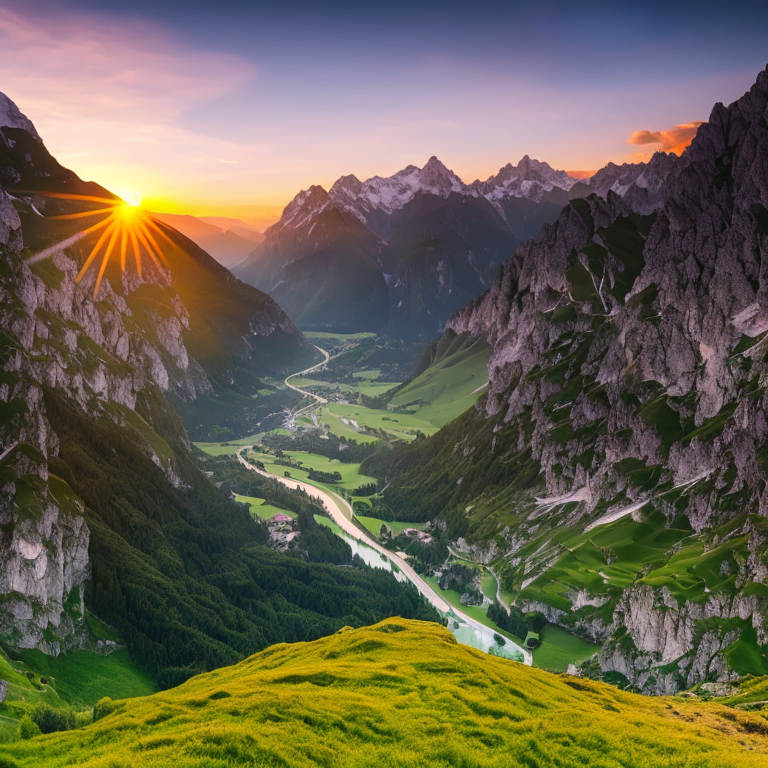

In [12]:
final_image = result['sample'][0]
final_image.save('result.png')
final_image